# CPSC532S Assignment 3:  RNNs for Language Modeling

In [58]:
from collections import Counter
from collections import defaultdict
from gensim.models import Word2Vec
from random import random
from nltk import word_tokenize
from nltk.translate.bleu_score import sentence_bleu
from torch import nn
from torch.autograd import Variable

import numpy as np
import torch
import torch.nn.functional as F
import json
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

# Data Acquisition


The goal of this assignment is to translate English to Pig Latin. For this assignment, you must download the data and extract it into `data/`. The dataset contains four files, each containing a single caption on each line. There are two files for training (English vs Pig Latin) and two files for validation. We should have 20,000 sentences (one sentence per image in Assignment 2) in the training captions and 500 sentences in the validation captions (five sentences per image in Assignment 2).

In [59]:
from google.colab import drive

drive.mount('/content/drive')

# Load the data into memory.
mscoco_train = json.load(open("/content/drive/My Drive/Colab Notebooks/data/train_captions.json"))
mscoco_val  = json.load(open('/content/drive/My Drive/Colab Notebooks/data/val_captions.json'))

mscoco_piglatin_train = json.load(open('/content/drive/My Drive/Colab Notebooks/data/piglatin_train_captions.json'))
mscoco_piglatin_val  = json.load(open('/content/drive/My Drive/Colab Notebooks/data/piglatin_val_captions.json'))

train_sentences = [entry['caption'] for entry in mscoco_train['annotations']]
val_sentences = [entry['caption'] for entry in mscoco_val['annotations']]

piglatin_train_sentences = [entry['caption'] for entry in mscoco_piglatin_train['annotations']]
piglatin_val_sentences = [entry['caption'] for entry in mscoco_piglatin_val['annotations']]

print(len(train_sentences))
print(len(val_sentences))
print(len(piglatin_train_sentences))
print(len(piglatin_val_sentences))
print(train_sentences[0])
print(piglatin_train_sentences[0])
print(val_sentences[0])
print(piglatin_val_sentences[0])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
20000
500
20000
500
A very clean and well decorated empty bathroom
Away eryvay eanclay andway ellway ecoratedday emptyway athroombay
Set of bananas hanging off of a banana tree.
Etsay ofway ananasbay anginghay offway ofway away ananabay eetray.


# Preprocessing

The code provided below creates word embeddings for you to use. After creating the vocabulary, we construct both one-hot embeddings and word2vec embeddings. 


In [60]:
import nltk
nltk.download('punkt')

sentences = train_sentences
piglatin_sentences = piglatin_train_sentences

# Lower-case the sentence, tokenize them and add <SOS> and <EOS> tokens
sentences = [["<SOS>"] + word_tokenize(sentence.lower()) + ["<EOS>"] for sentence in sentences]
piglatin_sentences = [["<SOS>"] + word_tokenize(sentence.lower()) + ["<EOS>"] for sentence in piglatin_sentences]

# Create the vocabulary. Note that we add an <UNK> token to represent words not in our vocabulary.
vocabularySize = 2000
word_counts = Counter([word for sentence in sentences for word in sentence])
piglatin_word_counts = Counter([word for sentence in piglatin_sentences for word in sentence])
word_counts = word_counts + piglatin_word_counts
vocabulary = ["<UNK>"] + [e[0] for e in word_counts.most_common(vocabularySize-1)]
word2index = {word:index for index,word in enumerate(vocabulary)}

# Build the one hot embeddings
one_hot_embeddings = np.eye(vocabularySize)


# Build the word2vec embeddings
wordEncodingSize = 300
filtered_sentences = [[word for word in sentence if word in word2index] for sentence in sentences]
piglatin_filtered_sentences = [[word for word in sentence if word in word2index] for sentence in piglatin_sentences]
all_filtered_sentences = filtered_sentences + piglatin_filtered_sentences
w2v = Word2Vec(all_filtered_sentences, min_count=0, size=wordEncodingSize)
w2v_embeddings = np.concatenate((np.zeros((1, wordEncodingSize)), w2v.wv.syn0))

# Define the max sequence length to be the longest sentence in the training data. 
maxSequenceLength = max([len(sentence) for sentence in sentences])
piglatin_maxSequenceLength = max([len(sentence) for sentence in piglatin_sentences])

if piglatin_maxSequenceLength > maxSequenceLength:
    maxSequenceLength = piglatin_maxSequenceLength

print(maxSequenceLength)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


57


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


# Utilities functions


Please look through the functions provided below carefully, as you will need to use all of them at some point in your assignment.

In [61]:
def preprocess_numberize(sentence):
    """
    Given a sentence, in the form of a string, this function will preprocess it
    into list of numbers (denoting the index into the vocabulary).
    """
    tokenized = word_tokenize(sentence.lower())
    # Add the <SOS>/<EOS> tokens and numberize (all unknown words are represented as <UNK>).
    tokenized = ["<SOS>"] + tokenized + ["<EOS>"]
    numberized = [word2index.get(word, 0) for word in tokenized]
    
    return numberized

def preprocess_one_hot(sentence):
    """
    Given a sentence, in the form of a string, this function will preprocess it
    into a numpy array of one-hot vectors.
    """
    numberized = preprocess_numberize(sentence)
    
    # Represent each word as it's one-hot embedding
    one_hot_embedded = one_hot_embeddings[numberized]
    
    return one_hot_embedded

def preprocess_word2vec(sentence):
    """
    Given a sentence, in the form of a string, this function will preprocess it
    into a numpy array of word2vec embeddings.
    """
    numberized = preprocess_numberize(sentence)
    
    # Represent each word as it's one-hot embedding
    w2v_embedded = w2v_embeddings[numberized]
    
    return w2v_embedded

def compute_bleu(reference_sentence, predicted_sentence):
    """
    Given a reference sentence, and a predicted sentence, compute the BLEU similary between them.
    """
    reference_tokenized = word_tokenize(reference_sentence.lower())
    predicted_tokenized = word_tokenize(predicted_sentence.lower())
    return sentence_bleu([reference_tokenized], predicted_tokenized)

%matplotlib inline
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize = (10, 10), dpi = 150)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words.split(' ') +['<EOS>'])

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

score1 = compute_bleu("<SOS>" + train_sentences[0], "<SOS>" + train_sentences[0])
score2 = compute_bleu("<SOS>" + train_sentences[0], "<SOS>" + train_sentences[5])

print('BLEU score distnace between \n  "' + train_sentences[0] + '" \nand\n  "'+ train_sentences[0] + '" \nis: ' + str(score1) +'\n\n')
print('BLEU score distnace between \n  "' + train_sentences[0] + '" \nand\n  "'+ train_sentences[5] + '" \nis: ' + str(score2) +'\n\n')


BLEU score distnace between 
  "A very clean and well decorated empty bathroom" 
and
  "A very clean and well decorated empty bathroom" 
is: 1.0


BLEU score distnace between 
  "A very clean and well decorated empty bathroom" 
and
  "A few people sit on a dim transportation system. " 
is: 0.1933853138176172




#Part 1: Encoder-Decoder Language Translation with Teacher-Forcing


## 1.1 Building a Language Decoder

We now implement a language decoder. For now, we will have the decoder take a single training sample at a time (as opposed to batching). For our purposes, we will also avoid defining the embeddings as part of the model and instead pass in embedded inputs. While this is sometimes useful, as it learns/tunes the embeddings, we avoid doing it for the sake of simplicity and speed.

Remember to use LSTM hidden units!

In [62]:
 device = torch.device('cuda:0')

In [63]:
class DecoderLSTM(nn.Module):
    def __init__(self):
        super(DecoderLSTM, self).__init__()


        wordEncodingSize = 2000 
        self.hidden_size = 300
        
        # Your code goes here (~4 lines or less)
        self.lstm = nn.LSTM( wordEncodingSize, self.hidden_size).to(device)
        self.out = nn.Linear(self.hidden_size, vocabularySize).to(device)
        self.softmax = nn.LogSoftmax(dim=1)

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device = device) 

    def init_cell(self):
        return torch.zeros(1, 1, self.hidden_size, device = device) # Your code goes here (1 line)

    def forward(self, input_sentence , hidden, cell):
        #  #input = self.embedding(input_sentence).view(1, 1, -1)
         input=input_sentence.view(1,1,-1)
         output, (hidden,cell) = self.lstm(input, (hidden,cell))
         #shape of output : 1*1* hidden_size
         output = self.out(output[0])
         #shape of output (1*1*length_of_vocab)
        
         return output, hidden, cell



## 1.2.  Building Language Encoder

We now build a language encoder, which will encode an input word by word, and ultimately output a hidden state that we can then be used by our decoder.

In [64]:
class EncoderLSTM(nn.Module):
    # Your code goes here
    def __init__(self):
        super(EncoderLSTM, self).__init__()
        
        self.hidden_size = 300
        wordEncodingSize = 2000
        
        # Your code goes here (~3 lines)
        # self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size= wordEncodingSize, 
                          hidden_size=self.hidden_size).to(device)
        

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
       

    def init_cell(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
      

    def forward(self, input_sentence, hidden, cell):
        # Your code goes here (~2 lines of code)
        embedded=input_sentence.view(1,1,-1) #do not need embedding
        #embedded = self.embedding(input).view(1, 1, -1)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        return output, hidden, cell
        
                

## 1.3. Connecting Encoder to Decoder and Train End-to-End and Train with Teacher Forcing

We now connect our newly created encoder with our decoder, to train an end-to-end seq2seq architecture. 

For the purposes of Part 1, the only interaction between the encoder and the decoder is that the *last hidden state of the encoder is used as the initial hidden state of the decoder*. This will be different for Part 2 and 3 where we will extend this punction.

In [66]:
def train(input_sentence, output_sentence, encoder,
          decoder, encoder_optimizer,
          decoder_optimizer, 
          criterion,
          teacher_forcing_ratio = 1,
          decoderType = "LSTM",
          embeddings = one_hot_embeddings): 
    """
    Given a single training sample, go through a single step of training.
    """
    use_teacher_forcing = True if np.random.rand() < teacher_forcing_ratio else False
     # Your code goes here

    encoder = encoder.to(device)
    decoder = decoder.to(device)
    encoder_hidden=encoder.init_hidden()
    encoder_cell = encoder.init_cell()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # print("input_sentence")
    # print(input_sentence)
    #embedding
    #input_tensor = torch.Tensor(preprocess_one_hot(input_sentence))
    input_tensor = torch.Tensor([one_hot_embeddings[word2index.get(word, 0)] for word in input_sentence])
    #output_tensor = torch.Tensor(preprocess_numberize(input_sentence))
    output_tensor = torch.Tensor([word2index.get(word, 0) for word in output_sentence]).long()
    # print(output_tensor.size()) #[10,]
    # print(output_tensor)
    # print("output_tensor")
    # print(output_tensor.size())
    input_length=input_tensor.size(0)
    # print("input_length",input_length)
    target_length =output_tensor.size(0)

    encoder_outputs = torch.zeros(maxSequenceLength, encoder.hidden_size, device=device)
  
    loss = 0
    for ei in range(input_length): 
        encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei].to(device), 
                                                 encoder_hidden, encoder_cell)
        encoder_outputs[ei] = encoder_output[0, 0] 
       
       #grab the start token
    decoder_input = torch.Tensor([one_hot_embeddings[word2index['<SOS>']]])
    # print("decoder_input")
    # print(decoder_input.size())
  
    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell

    if decoderType == "LSTM": 
        if use_teacher_forcing: #feed the target as the next input
            # Your code goes here
            for di in range(target_length):
              decoder_output, decoder_hidden, decoder_cell = decoder(decoder_input.to(device), decoder_hidden, decoder_cell)
              #outputs[di]=decoder_output
              loss += criterion(decoder_output, output_tensor[di].unsqueeze(0).to(device))
              decoder_input = torch.Tensor(one_hot_embeddings[output_tensor[di]])  # Teacher forcing
            
        elif not use_teacher_forcing:
            # Your code goes here
            for di in range(target_length):
              decoder_output, decoder_hidden, decoder_cell = decoder(decoder_input.to(device), decoder_hidden, decoder_cell)
              topv, topi = decoder_output.data.topk(1) # 
              decoder_input = torch.Tensor(one_hot_embeddings[topi.squeeze(0).detach()]) # detach from history as input
              loss += criterion(decoder_output, output_tensor[di].unsqueeze(0).to(device))
              
              if np.argmax(decoder_input.numpy()) == word2index['<EOS>']: #
                  break 
 
    if decoderType == "AttentionLSTM": 
      if use_teacher_forcing: 
          #   # Your code goes here
        for di in range(target_length):
              decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(decoder_input.to(device), decoder_hidden, decoder_cell, encoder_outputs)
              loss += criterion(decoder_output, output_tensor[di].unsqueeze(0).to(device))
              decoder_input = torch.Tensor(one_hot_embeddings[output_tensor[di]])  # Teacher forcing

      elif not use_teacher_forcing:
            # Your code goes here
            for di in range(target_length):
              decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(decoder_input.to(device), decoder_hidden, decoder_cell, encoder_outputs)
              topv, topi = decoder_output.data.topk(1) # 
              decoder_input =  torch.Tensor(one_hot_embeddings[topi.squeeze(0).detach()]) # detach from history as input
              loss += criterion(decoder_output, output_tensor[di].unsqueeze(0).to(device))
              
              if decoder_input.item() == '<EOS>': #
                  break 
 

    if decoderType == "Transformer":

      output_sentence_tensor = torch.Tensor([one_hot_embeddings[word2index.get(word, 0)] for word in output_sentence[:-1]])
      decoder_output, encoder_attention_weights, self_attention_weights = decoder(output_sentence_tensor, encoder_outputs)
      # print("decoder_output_size")#[1, 9, 2000])
      # print(decoder_output.size()) 
      for di in range(target_length - 1):
            loss += criterion(decoder_output[0, di].unsqueeze(0), output_tensor[di + 1].unsqueeze(0).to(device))
      
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    final_loss=loss.item()/target_length
    # Your code goes here
    return final_loss



In [ ]:
# Train the model and monitor the loss. Remember to use Adam optimizer and CrossEntropyLoss
encoder = EncoderLSTM()
decoder = DecoderLSTM()
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.0005) 
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=0.0005) 
criterion = nn.CrossEntropyLoss()
epochs = 5

print("Start training end-to-end network ......")
for epoch in range(epochs):
    epoch_loss=[]
    count=0
    for id, sentence in enumerate(filtered_sentences): 
        target_variable = piglatin_filtered_sentences[id]
        loss = train(sentence, target_variable, encoder, decoder, 
                     encoder_optimizer, decoder_optimizer, 
                     criterion, teacher_forcing_ratio = 1, 
                     decoderType="LSTM")
        
        count = count+1
        if count%500==0:
            print("Single sentence Loss (epoch %d) : %f" % (epoch, loss))
        epoch_loss.append(loss)
        
    print("Loss (epoch %d) : %f" % (epoch, np.sum(epoch_loss)/len(filtered_sentences))) 

Start training end-to-end network ......
Single sentence Loss (epoch 0) : 3.012568
Single sentence Loss (epoch 0) : 2.756030
Single sentence Loss (epoch 0) : 3.107305
Single sentence Loss (epoch 0) : 3.840675
Single sentence Loss (epoch 0) : 3.324530
Single sentence Loss (epoch 0) : 1.962286
Single sentence Loss (epoch 0) : 3.887178
Single sentence Loss (epoch 0) : 4.523564
Single sentence Loss (epoch 0) : 4.102624
Single sentence Loss (epoch 0) : 2.668831
Single sentence Loss (epoch 0) : 2.974476
Single sentence Loss (epoch 0) : 3.316699
Single sentence Loss (epoch 0) : 4.129482
Single sentence Loss (epoch 0) : 1.841648
Single sentence Loss (epoch 0) : 4.362152
Single sentence Loss (epoch 0) : 3.062619
Single sentence Loss (epoch 0) : 3.370016
Single sentence Loss (epoch 0) : 3.109073
Single sentence Loss (epoch 0) : 2.468184
Single sentence Loss (epoch 0) : 4.872273
Single sentence Loss (epoch 0) : 3.041341
Single sentence Loss (epoch 0) : 2.519232
Single sentence Loss (epoch 0) : 2.

## 1.4. Building Language Decoder MAP Inference

We now define a method to perform inference with our decoder. 

In [73]:
def inference(sentence, encoder, decoder, decoderType="LSTM", embeddings=one_hot_embeddings, max_length=maxSequenceLength):
    
    input_tensor = torch.Tensor(preprocess_one_hot(sentence))
    #print(input_tensor)
    input_length = input_tensor.shape[0]
   
    # Initialize encoder & decoder 
    encoder_hidden = encoder.init_hidden()
    encoder_cell = encoder.init_cell()
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size).to(device)
    # docoder_hideen=decoder.init_hidden()
    # docoder_cell=decoder.init_cell()

    for ei in range(1,input_length):
        # Iteratively run the encoder 
        # 1. Get the current word index
        # 2. Convert to a 1-hot encoding
        # 3. Run one step of the encoder
        encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei].to(device), 
                                                               encoder_hidden, encoder_cell)
        encoder_outputs[ei] += encoder_output[0, 0]
        # 4. Save the encoder hidden states for future processing

    # Set the initial hidden and cell state of the RNN decoder to the last 
    # hidden and cell state of the encoder
    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell
    # Start the decoding with <SOS> token
    #decoder_input = torch.Tensor(preprocess_one_hot['<SOS>']]])
    decoder_input = torch.Tensor([one_hot_embeddings[word2index['<SOS>']]]) 
    decoder_attentions=torch.zeros(max_length,max_length) 
    # Iterate up to the max_length of output
    word_list=[]
        
    for i in range(max_length):
        if decoderType == "LSTM": 
            decoder_output, decoder_hidden, decoder_cell = decoder(decoder_input.to(device), decoder_hidden, decoder_cell)
              
            topv, topi = decoder_output.data.topk(1) # 
              # detach from history as input
              # print("index")
              # print(topi.squeeze().item())
            if topi.squeeze(0).item() == word2index['<EOS>']: #top 1 index match
                word_list.append('<EOS>')
                break
            else:
                word_list.append(vocabulary[topi.squeeze().item()])

            decoder_input = torch.Tensor(one_hot_embeddings[topi.squeeze().detach()])
            # Run the simple decoder 

        if decoderType == "AttentionLSTM":
            # Run the attention decoder (this will be done in Part 2)
            decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(decoder_input.to(device), decoder_hidden, decoder_cell, encoder_outputs)
            # decoder_attentions[i]=decoder_attention[0,0]
            # print("decoder_attention.size")
            # print(decoder_attention[0,0].size())
            decoder_attentions[i] = decoder_attention.squeeze() #57*1

            topv, topi = decoder_output.data.topk(1)
            if topi.squeeze(0).item() == word2index['<EOS>']: #top 1 index match
                word_list.append('<EOS>')
                break
            else:
                word_list.append(vocabulary[topi.squeeze(0).item()])

            decoder_input = torch.Tensor(one_hot_embeddings[topi.squeeze(0).detach()])

        if decoderType == "Transformer":
          decoder_output, encoder_attention_weights, self_attention_weights = decoder(decoder_input.to(device), encoder_outputs.to(device))  
          #   # Run the transformer decoder (this will be done in Part 3)
          topv, topi = decoder_output[0,i].data.topk(1)
          if topi.squeeze(0).item() == word2index['<EOS>']: #top 1 index match
              word_list.append('<EOS>')
              break
          else:
              word_list.append(vocabulary[topi.squeeze(0).item()])
              decoder_output.to(device)
              decoder_input = torch.cat((decoder_input, torch.Tensor(one_hot_embeddings[topi.squeeze(0).detach()]).unsqueeze(0)), dim = 0)

        decoder_attentions = [encoder_attention_weights, self_attention_weights]
    return word_list, decoder_attentions




In [ ]:

# Lets test it 
sentence = "A very clean and well decorated empty bathroom" 
print(type(sentence))
#input_sentence = ["<SOS>"] + word_tokenize(sentence.lower()) + ["<EOS>"] 
output_sentence, _ = inference(sentence, encoder, decoder, decoderType="LSTM")

print("English: " + sentence)
print("Pig Latin: ", ' '.join(output_sentence[1:-1]))


<class 'str'>
English: A very clean and well decorated empty bathroom
Pig Latin:  erethay andway away eryvay allsmay oldway andway otway ocksclay


## 1.5. Building Language Decoder Sampling Inference

We now modify the inference method to sample from the distribution outputted by the LSTM rather than taking the most probable word.

It might be useful to take a look at the output of your model and (depending on your implementation) modify it so that the outputs sum to 1. 

In [ ]:
import numpy.random as ra

def sampling_inference(sentence, encoder, decoder, decoderType="LSTM", embeddings=one_hot_embeddings, max_length=maxSequenceLength):
    input_tensor = torch.Tensor(preprocess_one_hot(sentence))
    input_length = input_tensor.shape[0]

    # Initialize encoder & decoder 

    encoder_hidden = encoder.init_hidden()
    encoder_cell = encoder.init_cell()
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size).to(device)

    for ei in range(1,input_length):
        # Iteratively run the encoder 
        # 1. Get the current word index
        # 2. Convert to a 1-hot encoding
        # 3. Run one step of the encoder
        encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei].to(device), encoder_hidden, encoder_cell)
        # 4. Save the encoder hidden states for future processing
        encoder_outputs[ei] = encoder_output[0, 0]

    # Set the initial hidden and cell state of the RNN decoder to the last 
    # hidden and cell state of the encoder
    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell
    # Start the decoding with <SOS> token
    decoder_input = torch.Tensor([one_hot_embeddings[word2index['<SOS>']]])  
    word_list = []
    decoder_attentions = torch.zeros(max_length, max_length)
    # Iterate up to the max_length of output
    for i in range(max_length):
        if decoderType == "LSTM": 
            # Run the simple decoder 
            decoder_output, decoder_hidden, decoder_cell = decoder(decoder_input.to(device), decoder_hidden, decoder_cell)
            decoder_prob = F.softmax(decoder_output)
            #check if sum(decoder_output)==1
            # cum_prob = np.cumsum(decoder_output)
            # randnum = ra.uniform(0, 1, 1)
            # index=range(1,2000)
            # topi = [int(index[np.argwhere(cum_prob == min(cum_prob[(cum_prob - randnum) > 0]))])]
            topi = torch.multinomial(decoder_prob, 1)
            if topi == word2index['<EOS>']: #top 1 index match
                word_list.append('<EOS>')
                break
            else:
                word_list.append(vocabulary[topi])

            decoder_input = torch.Tensor(one_hot_embeddings[topi])

        if decoderType == "AttentionLSTM":
          pass
            # Run the attention decoder (this will be done in Part 2)
            # decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
            # decoder_attentions[i] = decoder_attention[0, 0]
            # decoder_prob=decoder_output
            # topi = torch.multinomial(decoder_prob, 1)

            # if topi == word2index['<EOS>']: #top 1 index match
            #     word_list.append('<EOS>')
            #     break
            # else:
            #     word_list.append(vocabulary[topi])

            # decoder_input = torch.Tensor(one_hot_embeddings[topi])

        if decoderType == "Transformer":
          pass
            # Run the transformer decoder (this will be done in Part 3)


    return word_list, decoder_attentions

    

In [ ]:
# Lets test it 
sentence = "A very clean and well decorated empty bathroom" 
#input_sentence = ["<SOS>"] + word_tokenize(sentence.lower()) + ["<EOS>"] 

print("English: " + sentence)

for i in range(5):
    output_sentence, _ = sampling_inference(sentence, encoder, decoder, decoderType="LSTM")
    # print(output_sentence)
    print("Pig Latin: ", ' '.join(output_sentence[1:-1]))

English: A very clean and well decorated empty bathroom
Pig Latin:  atcay outsideway away eryvay efrigeratorray andway asketbay asesvay asesvay
Pig Latin:  anymay away eryvay ellway ightbray eryvay eanclay andway appliancesway
Pig Latin:  adylay eamcray away eryvay allsmay ightbray andway oldway orkway
Pig Latin:  erethay andway away eryvay allsmay idgefray andway anway owertay
Pig Latin:  eythay andway away eryvay igbay aterway andway orestay idgefray intoway


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


## 1.6. Testing 

We must now define a method that allows us to do inference using the seq2seq architecture. We then run the 500 validation captions through this method, and ultimately compare the **reference** and **generated** sentences using our **BLEU** similarity score method defined above, to identify the average BLEU score.

In [ ]:
# Perform inference for all validation sequences and report the average BLEU score
avg_score=[]

# iterate over the validation set 
for idx, input_sentence in enumerate(val_sentences): 
    word_list, _ = inference(input_sentence, encoder, decoder, decoderType="LSTM")
    output_sentence = ' '.join(word_list[:-1])
    target_sentence = piglatin_val_sentences[idx]
    # print(target_sentence)
    score = compute_bleu('<SOS> '+target_sentence, output_sentence)
    avg_score.append(score)
    if idx < 10 :
        print('BLEU score distance between \n  "' + target_sentence + '" \nand\n  "'+ output_sentence + '" \n is: ' + str(score) +'\n\n')

print(avg_score)
print(len(val_sentences))
final_score = np.sum(avg_score)/len(val_sentences)
print("Average BLUE score : %f" % (final_score)) 


# EXPECTED < Average BLUE score (ArgMAX inference): 0.464803 > 
# EXPECTED < Average BLUE score (sampling inference): 0.477803 > 

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU score distance between 
  "Etsay ofway ananasbay anginghay offway ofway away ananabay eetray." 
and
  "<SOS> ourfay ofway ananasbay anginghay omfray away ananabay onway omesay ooksbay ." 
 is: 5.502798075292677e-78


BLEU score distance between 
  "Otway unchesbay ofway eengray ananasbay onway ananabay eestray." 
and
  "<SOS> otway ehindbay otway eengray ananasbay onway eengray ananasbay ." 
 is: 0.317023313852343


BLEU score distance between 
  "Anymay alendarscay andway unchesbay ofway ananasbay anginghay onway away allway." 
and
  "<SOS> anymay antsplay andway omesay ananasbay ittingsay onway away oodenway allway ." 
 is: 0.25400289715190977


BLEU score distance between 
  "Ustersclay ofway ananasbay andway icturespay anginghay onway away allway." 
and
  "<SOS> ultiplemay ofway ariousvay andway anginghay anginghay omfray away allway onway itway ." 
 is: 3.9543559515104263e-78


BLEU score distance between 
  "otway ogsday atthay ooklay otay ebay ightingfay oneway anotherway" 

## 1.7. Experiment with Teacher Forcing

Redo steps 1.3 and 1.6 with teacher_forcing_ratio = 0.9 and 0.8. Comment on the results, speed of convergence and the quality of results. Note that in most real scenarious the teacher forcing is actually annealed; starting with teacher forcing = 1.

In [ ]:
# Train the model and monitor the loss. Remember to use Adam optimizer and CrossEntropyLoss
encoder = EncoderLSTM()
decoder = DecoderLSTM()
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.0005) 
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=0.0005) 
criterion = nn.CrossEntropyLoss()
epochs = 5

print("Start training end-to-end network ......")
for epoch in range(epochs):
    epoch_loss=[]
    count=0
    for id, sentence in enumerate(filtered_sentences): #use 1/4 data
        target_variable = piglatin_filtered_sentences[id]
        loss = train(sentence, target_variable, encoder, decoder, 
                     encoder_optimizer, decoder_optimizer, 
                     criterion, teacher_forcing_ratio = 0.90, 
                     decoderType="LSTM")
        
        count = count+1
        if count%500==0:
            print("Single sentence Loss (epoch %d) : %f" % (epoch, loss))
        epoch_loss.append(loss)
        
    print("Loss (epoch %d) : %f" % (epoch, np.sum(epoch_loss)/len(filtered_sentences))) 


# Perform inference for all validation sequences and report the average BLEU score

Start training end-to-end network ......
Single sentence Loss (epoch 0) : 3.013966
Single sentence Loss (epoch 0) : 2.777706
Single sentence Loss (epoch 0) : 3.095503
Single sentence Loss (epoch 0) : 3.972081
Single sentence Loss (epoch 0) : 3.411978
Single sentence Loss (epoch 0) : 2.053121
Single sentence Loss (epoch 0) : 4.055555
Single sentence Loss (epoch 0) : 4.572119
Single sentence Loss (epoch 0) : 4.297745
Single sentence Loss (epoch 0) : 2.684850
Single sentence Loss (epoch 0) : 3.064920
Single sentence Loss (epoch 0) : 3.793001
Single sentence Loss (epoch 0) : 4.215665
Single sentence Loss (epoch 0) : 1.955022
Single sentence Loss (epoch 0) : 4.384653
Single sentence Loss (epoch 0) : 2.988850
Single sentence Loss (epoch 0) : 3.462897
Single sentence Loss (epoch 0) : 3.072012
Single sentence Loss (epoch 0) : 2.661789
Single sentence Loss (epoch 0) : 5.012444
Single sentence Loss (epoch 0) : 3.116217
Single sentence Loss (epoch 0) : 2.642205
Single sentence Loss (epoch 0) : 4.

In [ ]:
avg_score=[]

# iterate over the validation set 
for idx, input_sentence in enumerate(val_sentences): 
    word_list, _ = inference(input_sentence, encoder, decoder, decoderType="LSTM")
    output_sentence = ' '.join(word_list[:-1])
    target_sentence = piglatin_val_sentences[idx]
    # print(target_sentence)
    score = compute_bleu('<SOS> '+target_sentence, output_sentence)
    avg_score.append(score)
    if idx < 10 :
        print('BLEU score distance between \n  "' + target_sentence + '" \nand\n  "'+ output_sentence + '" \n is: ' + str(score) +'\n\n')

print(avg_score)
print(len(val_sentences))
final_score = np.sum(avg_score)/len(val_sentences)
print("Average BLUE score : %f" % (final_score)) 

BLEU score distance between 
  "Etsay ofway ananasbay anginghay offway ofway away ananabay eetray." 
and
  "<SOS> etsay ofway oodfay , upway otay aketay away acefay ." 
 is: 0.31455601883230705


BLEU score distance between 
  "Otway unchesbay ofway eengray ananasbay onway ananabay eestray." 
and
  "<SOS> otway ocksclay ofway eengray ananasbay onway isplayday ." 
 is: 0.4412739850976206


BLEU score distance between 
  "Anymay alendarscay andway unchesbay ofway ananasbay anginghay onway away allway." 
and
  "<SOS> anymay ocksclay ithway andway ofway iledpay anginghay onway it'sway idesay ." 
 is: 0.23397625978961173


BLEU score distance between 
  "Ustersclay ofway ananasbay andway icturespay anginghay onway away allway." 
and
  "<SOS> enderblay ullfay ofway andway ananasbay andway anginghay onway away allway ." 
 is: 0.4001601601922499


BLEU score distance between 
  "otway ogsday atthay ooklay otay ebay ightingfay oneway anotherway" 
and
  "<SOS> otway ogsday atthay avehay otay one

In [ ]:
# Your code goes here
# Train the model and monitor the loss. Remember to use Adam optimizer and CrossEntropyLoss
encoder = EncoderLSTM()
decoder = DecoderLSTM()
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.0005) 
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=0.0005) 
criterion = nn.CrossEntropyLoss()
epochs = 5

print("Start training end-to-end network ......")
for epoch in range(epochs):
    epoch_loss=[]
    count=0
    for id, sentence in enumerate(filtered_sentences):
        target_variable = piglatin_filtered_sentences[id]
        loss = train(sentence, target_variable, encoder, decoder, 
                     encoder_optimizer, decoder_optimizer, 
                     criterion, teacher_forcing_ratio = 0.80, 
                     decoderType="LSTM")
        
        count = count+1
        if count%500==0:
            print("Single sentence Loss (epoch %d) : %f" % (epoch, loss))
        epoch_loss.append(loss)
        
    print("Loss (epoch %d) : %f" % (epoch, np.sum(epoch_loss)/len(filtered_sentences))) 


# Perform inference for all validation sequences and report the average BLEU score
avg_score=[]

# iterate over the validation set 
for idx, input_sentence in enumerate(val_sentences): 
    word_list, _ = inference(input_sentence, encoder, decoder, decoderType="LSTM")
    output_sentence = ' '.join(word_list[:-1])
    target_sentence = piglatin_val_sentences[idx]
    # print(target_sentence)
    score = compute_bleu('<SOS> '+target_sentence, output_sentence)
    avg_score.append(score)
    if idx < 10 :
        print('BLEU score distance between \n  "' + target_sentence + '" \nand\n  "'+ output_sentence + '" \n is: ' + str(score) +'\n\n')

print(avg_score)
print(len(val_sentences))
final_score = np.sum(avg_score)/len(val_sentences)
print("Average BLUE score : %f" % (final_score))  

Start training end-to-end network ......
Single sentence Loss (epoch 0) : 2.934896
Single sentence Loss (epoch 0) : 2.814061
Single sentence Loss (epoch 0) : 3.186958
Single sentence Loss (epoch 0) : 3.944696
Single sentence Loss (epoch 0) : 3.393381
Single sentence Loss (epoch 0) : 2.081439
Single sentence Loss (epoch 0) : 4.211212
Single sentence Loss (epoch 0) : 4.510678
Single sentence Loss (epoch 0) : 4.328499
Single sentence Loss (epoch 0) : 2.706542
Single sentence Loss (epoch 0) : 3.157222
Single sentence Loss (epoch 0) : 3.321675
Single sentence Loss (epoch 0) : 4.250051
Single sentence Loss (epoch 0) : 2.216181
Single sentence Loss (epoch 0) : 4.386589
Single sentence Loss (epoch 0) : 3.025132
Single sentence Loss (epoch 0) : 3.271436
Single sentence Loss (epoch 0) : 3.104487
Single sentence Loss (epoch 0) : 2.704174
Single sentence Loss (epoch 0) : 5.123661
Single sentence Loss (epoch 0) : 3.095636
Single sentence Loss (epoch 0) : 2.755634
Single sentence Loss (epoch 0) : 2.

## 1.8. Encoding as Generic Feature Representation

We now use the final hidden state of our encoder, to identify the nearest neighbor amongst the training sentences for each sentence in our validation data.

It would be effective to first define a method that would generate all of the hidden states and store these hidden states **on the CPU**, and then loop over the generated hidden states to identify/output the nearest neighbors.

In [ ]:
def final_encoder_hidden(sentence):
    # Your code goes here
    input_tensor = torch.Tensor(preprocess_one_hot(sentence))
    input_length = input_tensor.shape[0]
    
    encoder_hidden = encoder.init_hidden()
    encoder_cell = encoder.init_cell()

    for ei in range(1,input_length):
        # Iteratively run the encoder 
        _, encoder_hidden, encoder_cell = encoder(input_tensor[ei].to(device), encoder_hidden, encoder_cell)
    
    return encoder_hidden


# Now run all training data and validation data to store hidden states
    # Your code goes here

train_hidden_state=[]

for sentence in train_sentences:
  train_hidden_state.append(final_encoder_hidden(sentence)[0,0].detach().cpu().numpy())

val_hidden_state = []
for sentence in val_sentences:
    val_hidden_state.append(final_encoder_hidden(sentence)[0, 0].detach().cpu().numpy())

# Now get nearest neighbors and print
train_hidden_state = np.array(train_hidden_state)
val_hidden_state = np.array(val_hidden_state)

for i in range(10):
    index = np.argmin(np.sqrt(np.sum((train_hidden_state - val_hidden_state[i]) ** 2, 1)))
    print('Validation sentence: ', val_sentences[i])
    print('Most similar training sentence: ', train_sentences[index])

Validation sentence:  Set of bananas hanging off of a banana tree.
Most similar training sentence:  Bunches of bananas hanging from fire on a line.
Validation sentence:  Two bunches of green bananas on banana trees.
Most similar training sentence:  Bunches of green bananas still on the plant.
Validation sentence:  Many calendars and bunches of bananas hanging on a wall.
Most similar training sentence:  Many propeller plans and biplanes on display in a museum.
Validation sentence:  Clusters of bananas and pictures hanging on a wall.
Most similar training sentence:  Bunches of bananas sitting and hanging inside of a store.
Validation sentence:  two dogs that look to be fighting one another
Most similar training sentence:  Two horses stand in a sloped field of grass
Validation sentence:  Two dogs fighting with one on his back on the ground
Most similar training sentence:  TWO DOGS LYING ON A BED ON TOP OF THE COVERS
Validation sentence:  Bunches of green bananas hanging down from trees.
M

# Part 2: Attention LSTM Decoder

## 2.1. Implementing Additive Attention

In [ ]:

class AdditiveAttention(nn.Module):
    def __init__(self, hidden_size):
        super(AdditiveAttention, self).__init__()
        self.hidden_size = hidden_size
        #a two layer fully-connected newtork hidden_size*2--> hidden_size, reul, hidden_size-->1
        self.attention_network = nn.Sequential(
                                    nn.Linear(hidden_size*2, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, 1)
                                 )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, queries, keys, values):
        """The forward pass of the additive attention mechanism.

        Arguments:
            queries: The current decoder hidden state. (batch_size x hidden_size)
            keys: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)
            values: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)

        Returns:
            context: weighted average of the values (batch_size x 1 x hidden_size)
            attention_weights: Normalized attention weights for each encoder hidden state. (batch_size x 1 x seq_len)

            The attention_weights must be a softmax weighting over the seq_len annotations.
        """

        # ------------
        # Your code goes here
        # ------------
        # batch_size, seq_len, hidden_size = keys.size()
        batch_size=1
        #print(keys.shape()) #max_seq * hidden_size 
        keys=keys.unsqueeze(0)
        keys = keys.to(device); values = values.to(device)
        # batch_size, seq_len, hidden_size = keys.size()
        # print(queries.size())
        expanded_queries = queries.unsqueeze(1).expand_as(keys) #size is batch_size x seq_len x hidden_size
        concat_inputs = torch.cat((expanded_queries, keys),2)
        unnormalized_attention = self.attention_network(concat_inputs.view(-1, self.hidden_size * 2)).view(batch_size,  maxSequenceLength, 1)
        attention_weights = self.softmax(unnormalized_attention) #size is batch_size x seq_len x 1
        # print("value_size") #([57, 300])
        # print(values.size())
        context = torch.bmm(attention_weights.transpose(1,2), values.unsqueeze(0))
        # context =  torch.unsqueeze(torch.sum(attention_weights.squeeze(1)* values, 1), 1)
        # attention_weights = attention_weights.view(batch_size, 1, -1)

        return context, attention_weights

## 2.2. Attention Decoder

In [ ]:
class AttentionDecoder(nn.Module):
    def __init__(self):
        super(AttentionDecoder, self).__init__()

        self.hidden_dim = 300
        wordEncodingSize = 2000
        self.dropout_p = 0.1
        self.linear_input = nn.Linear(wordEncodingSize, self.hidden_dim)
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(self.hidden_dim*2, self.hidden_dim)
        self.attention = AdditiveAttention(hidden_size=self.hidden_dim)
        self.linear = nn.Linear(self.hidden_dim, vocabularySize)
        self.hidden = self.init_hidden()
        self.cell = self.init_cell()
        

    def init_hidden(self):    
        return torch.randn(1,1, self.hidden_dim).cuda()

    def init_cell(self):
        return torch.randn(1,1, self.hidden_dim).cuda()

    def forward(self, input_sentence, hidden, cell, encoder_hidden_states):
        

        embed = self.dropout(self.linear_input(input_sentence.view(1,-1)))#batch_size x seq_len x hidden_size 
        #embed=embed.unsqueeze(0)
        # ------------
        # Your code goes here
        # ------------
        # print("embed_size")
        # print(embed.size())
        
        embed_current = embed
        context, attention_weights = self.attention(embed_current, encoder_hidden_states, encoder_hidden_states)
        # print("context_size") #([1, 1, 300])
        # # print(context.squeeze(1).size())
        # print("encoder_hidden_states")
        # print(encoder_hidden_states.size()) #torch.Size([57, 300])
        embed_and_context = torch.cat((embed_current, context.squeeze(1)), 1).unsqueeze(0)
        
        # print(embed_and_context.size())
        output, (hidden,cell) = self.lstm(embed_and_context,(hidden,cell))
         #shape of output : 1*1* hidden_size
        output = self.linear(output[0])
        
        return output, hidden, cell, attention_weights



## 2.3. Training Attention Decoder

Note that you will need to modify the train() procedure for Part 1 to handles the AttentionLSTM.

In [ ]:
encoder2 = EncoderLSTM()
decoder2 = AttentionDecoder()
encoder2_optimizer = torch.optim.Adam(encoder2.parameters(), lr=0.0005) 
decoder2_optimizer = torch.optim.Adam(decoder2.parameters(), lr=0.0005) 
criterion = nn.CrossEntropyLoss()
epochs = 5

print("Start training end to end network ......")
for epoch in range(epochs):
    epoch_loss=[]
    count=0
    for id, sentence in enumerate(filtered_sentences):
        target_variable = piglatin_filtered_sentences[id]
        loss = train(sentence, target_variable, encoder2, decoder2, 
                     encoder2_optimizer, decoder2_optimizer, 
                     criterion, teacher_forcing_ratio = 1, decoderType="AttentionLSTM")
        count = count+1
        if count%500==0:
            print("Single sentence Loss (epoch %d) : %f" % (epoch, loss))
        epoch_loss.append(loss)
        
    print("Loss (epoch %d) : %f" % (epoch, np.sum(epoch_loss)/len(filtered_sentences))) 

Start training end to end network ......
Single sentence Loss (epoch 0) : 3.013273
Single sentence Loss (epoch 0) : 2.430466
Single sentence Loss (epoch 0) : 3.077810
Single sentence Loss (epoch 0) : 3.434087
Single sentence Loss (epoch 0) : 2.816122
Single sentence Loss (epoch 0) : 2.052372
Single sentence Loss (epoch 0) : 3.731321
Single sentence Loss (epoch 0) : 4.410732
Single sentence Loss (epoch 0) : 3.906038
Single sentence Loss (epoch 0) : 2.654846
Single sentence Loss (epoch 0) : 2.908526
Single sentence Loss (epoch 0) : 2.979530
Single sentence Loss (epoch 0) : 4.075023
Single sentence Loss (epoch 0) : 1.856530
Single sentence Loss (epoch 0) : 4.117086
Single sentence Loss (epoch 0) : 2.876479
Single sentence Loss (epoch 0) : 3.323626
Single sentence Loss (epoch 0) : 2.730329
Single sentence Loss (epoch 0) : 1.881708
Single sentence Loss (epoch 0) : 4.637541
Single sentence Loss (epoch 0) : 2.659431
Single sentence Loss (epoch 0) : 2.256354
Single sentence Loss (epoch 0) : 2.

## 2.4. Testing Attention Decoder
Note that you will need to modify the inference() procedure for Part 1 to handle Attention LSTM

In [ ]:
avg_score=[]

# iterate over the validation set 
for idx, input_sentence in enumerate(val_sentences): 
    # output_sentence, _ = inference(...)
    # target_sentence = ... 
    # score = compute_blue(...)
    output_sentence, _ = inference(input_sentence, encoder2, decoder2, decoderType="AttentionLSTM")
    target_sentence = piglatin_val_sentences[idx]
    score = compute_bleu('<SOS> ' + target_sentence, ' '.join(output_sentence[:-1]))
    
    avg_score.append(score)
    if idx < 10 :
        print('BLEU score distance between \n  "', target_sentence, '" \nand\n  "'+ ' '.join(output_sentence[1:-1]), '" \n is: ', str(score), '\n\n')

final_score = np.sum(avg_score)/len(val_sentences)
print("Average BLUE score : %f" % (final_score)) 


BLEU score distance between 
  " Etsay ofway ananasbay anginghay offway ofway away ananabay eetray. " 
and
  "etsay ofway ananasbay anginghay offway ofway away ananabay eetray . " 
 is:  1.0 


BLEU score distance between 
  " Otway unchesbay ofway eengray ananasbay onway ananabay eestray. " 
and
  "otway unchesbay ofway eengray ananasbay onway icksstay eestray . " 
 is:  0.7691605673134586 


BLEU score distance between 
  " Anymay alendarscay andway unchesbay ofway ananasbay anginghay onway away allway. " 
and
  "anymay oystay andway arietyvay ofway ananasbay anginghay onway away allway . " 
 is:  0.6298129992394241 


BLEU score distance between 
  " Ustersclay ofway ananasbay andway icturespay anginghay onway away allway. " 
and
  "ofway iecespay andway icturespay anginghay onway away allway . " 
 is:  0.5974178044844201 


BLEU score distance between 
  " otway ogsday atthay ooklay otay ebay ightingfay oneway anotherway " 
and
  "otway ogsday atthay ooklay otay ebay otnay oneway a

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Average BLUE score : 0.770173


## 2.5. Visualize Attention for Attention Decoder

Set of bananas hanging off of a banana tree.
etsay ofway ananasbay anginghay offway ofway away ananabay eetray .


<Figure size 1500x1500 with 0 Axes>

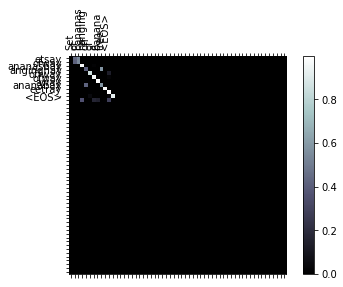

Two bunches of green bananas on banana trees.
otway unchesbay ofway eengray ananasbay onway ireway eestray .


<Figure size 1500x1500 with 0 Axes>

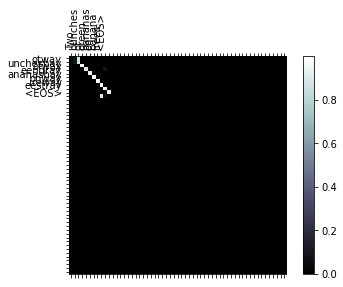

Many calendars and bunches of bananas hanging on a wall.
anymay oystay andway arietyvay ofway ananasbay anginghay onway away allway .


<Figure size 1500x1500 with 0 Axes>

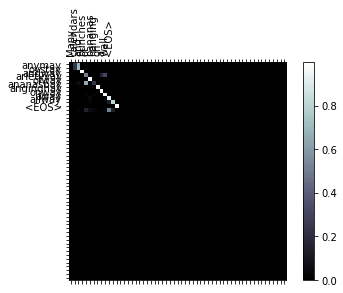

Clusters of bananas and pictures hanging on a wall.
ofway ananasbay andway icturespay anginghay onway away allway .


<Figure size 1500x1500 with 0 Axes>

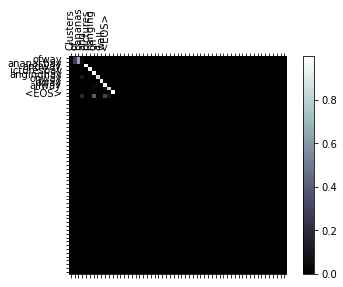

two dogs that look to be fighting one another
otway ogsday atthay ooklay otay ebay otnay oneway anotherway


<Figure size 1500x1500 with 0 Axes>

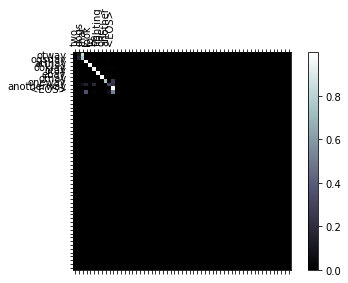

In [ ]:
# Your code goes here
for idx, input_sentence in enumerate(val_sentences[:5]): 
    word_list, attentions = inference(input_sentence, encoder2, decoder2, decoderType="AttentionLSTM")
    output_sentence = ' '.join(word_list[1:-1])
    print(input_sentence)
    print(output_sentence)
    showAttention(input_sentence, output_sentence, attentions.detach())

# Part 3: Transformer Decoder

## 3.1 Implement Scaled Dot Attention

In [67]:
#reference https://github.com/xinyaofan/CSC421/blob/master/Assignment/a3-code/a3-release/nmt.ipynb
class ScaledDotAttention(nn.Module):
    def __init__(self, hidden_size):
        super(ScaledDotAttention, self).__init__()

        self.hidden_size = 300

        self.Q = nn.Linear(hidden_size, hidden_size)
        self.K = nn.Linear(hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, hidden_size)
        self.softmax = nn.Softmax(dim=1)
        self.scaling_factor = torch.rsqrt(torch.tensor(self.hidden_size, dtype= torch.float))

    def forward(self, queries, keys, values):
        """The forward pass of the scaled dot attention mechanism.

        Arguments:
            queries: The current decoder hidden state, 2D or 3D tensor. (batch_size x (k) x hidden_size)
            keys: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)
            values: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)

        Returns:
            context: weighted average of the values (batch_size x k x hidden_size)
            attention_weights: Normalized attention weights for each encoder hidden state. (batch_size x seq_len x 1)

            The output must be a softmax weighting over the seq_len annotations.
        """

        # ------------
        # Your code goes here
        # ------------
        #batch_size=1 in this assignment

        # batch_size=1
        batch_size = 1
        if queries.dim() == 2:
            queries = queries.unsqueeze(0)
        if keys.dim() == 2:
            keys = keys.unsqueeze(0)
        if values.dim() == 2:
            values = values.unsqueeze(0)
        batch_size, seq_len, hidden_size = keys.size()
        q = self.Q(queries.view(-1,hidden_size)).view(batch_size,-1,hidden_size)  #batch_size x (k) x hidden_size
        k = self.K(keys.view(-1,hidden_size)).view(batch_size,seq_len, hidden_size) #batch_size x seq_len x hidden_size
        v = self.V(values.view(-1, hidden_size)).view(batch_size,seq_len, hidden_size) #batch_size x seq_len x hidden_size
        unnormalized_attention = self.scaling_factor * torch.bmm(k, q.transpose(1,2)) #batch_size x seq_len x k
        attention_weights = self.softmax(unnormalized_attention) #batch_size x seq_len x k
        context = torch.bmm(attention_weights.transpose(1,2), v) #batch_size*k*hidden_size
       
       #tensor.bmm tensor a (b,h,w) tensor b (b,w,m) output(b,h,m)
        return context, attention_weights


## 3.2. Implement Causal Scaled Dot Attention

The implementation should be nearly identical to the one above, but with mask.

In [68]:
#reference https://github.com/xinyaofan/CSC421/blob/master/Assignment/a3-code/a3-release/nmt.ipynb
class CausalScaledDotAttention(nn.Module):
    def __init__(self, hidden_size):
        super(CausalScaledDotAttention, self).__init__()

        self.hidden_size = hidden_size
        self.neg_inf = torch.tensor(-1e7).cuda()

        self.Q = nn.Linear(hidden_size, hidden_size)
        self.K = nn.Linear(hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, hidden_size)
        self.softmax = nn.Softmax(dim=1)
        self.scaling_factor = torch.rsqrt(torch.tensor(self.hidden_size, dtype= torch.float))

    def forward(self, queries, keys, values):
        """The forward pass of the scaled dot attention mechanism.

        NOTES:
            batch_size = 1

        Arguments:
            queries: The current decoder hidden state, 2D or 3D tensor. (batch_size x (k) x hidden_size)
                In training k = maxSequenceLength or length of the GT ourput sequence
                In testing k = length of currently decoded sub-sequence
            keys: The decoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)
            values: The decoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)

        Returns:
            context: weighted average of the values (batch_size x k x hidden_size)
            attention_weights: Normalized attention weights for each encoder hidden state. (batch_size x seq_len x 1)

            The output must be a softmax weighting over the seq_len annotations.
        """

        # ------------
        # Your code goes here
        # ------------  
        batch_size, seq_len, hidden_size = keys.size()
        print(batch_size)
        print(seq_len)
        print(hidden_size)
        q = self.Q(queries.view(-1, self.hidden_size)).view(batch_size, -1, self.hidden_size) #batch_size x (k) x hidden_size
        k = self.K(keys.view(-1,self.hidden_size)).view(batch_size, seq_len, self.hidden_size) #batch_size x seq_len x hidden_size
        v = self.V(values.view(-1, self.hidden_size)).view(batch_size, seq_len, self.hidden_size) #batch_size x seq_len x hidden_size
        unnormalized_attention = self.scaling_factor * torch.bmm(k, q.transpose(1,2)) #batch_size x seq_len x k
        mask = torch.tril(torch.ones(batch_size,seq_len,seq_len,dtype=torch.uint8)).transpose(1,2)
        unnormalized_attention[mask==0] = self.neg_inf
        attention_weights = self.softmax(unnormalized_attention)
        context = torch.bmm(attention_weights.transpose(1,2), v)

        return context, attention_weights

## 3.3. Implement Transformer Decoder

In [70]:
#reference https://github.com/xinyaofan/CSC421/blob/master/Assignment/a3-code/a3-release/nmt.ipynb
class TransformerDecoder(nn.Module):
    def __init__(self):
        super(TransformerDecoder, self).__init__()

        self.hidden_dim = 300
        wordEncodingSize = 2000
        self.dropout_p = 0.1
        self.num_layers = 3
        self.linear_input = nn.Linear(wordEncodingSize, self.hidden_dim)
        self.dropout = nn.Dropout(self.dropout_p)
        
        self.self_attentions = nn.ModuleList([CausalScaledDotAttention(
                                    hidden_size=self.hidden_dim, 
                                 ) for i in range(self.num_layers)])
        self.encoder_attentions = nn.ModuleList([ScaledDotAttention(
                                    hidden_size=self.hidden_dim, 
                                 ) for i in range(self.num_layers)])
        self.attention_mlps = nn.ModuleList([nn.Sequential(
                                    nn.Linear(self.hidden_dim, self.hidden_dim),
                                    nn.ReLU(),
                                 ) for i in range(self.num_layers)])

        self.linear = nn.Linear(self.hidden_dim, vocabularySize)

    def forward(self, input_sentence, annotations):
    
        #  Arguments:
        #     inputs: Input token indexes across a batch for all the time step. (batch_size x decoder_seq_len)
        #     annotations: The encoder hidden states for each step of the input.
        #                  sequence. (batch_size x seq_len x hidden_size)
        #     hidden_init: Not used in the transformer decoder
        # Returns:
        #     output: Un-normalized scores for each token in the vocabulary, across a batch for all the decoding time steps. (batch_size x decoder_seq_len x vocab_size)
        #     attentions: The stacked attention weights applied to the encoder annotations (batch_size x encoder_seq_len x dec
        embed = self.dropout(self.linear_input(input_sentence.to(device))).unsqueeze(0)
        
        encoder_attention_weights_list = []
        self_attention_weights_list = []
        contexts = embed
        batch_size, seq_len, hidden_size = contexts.size()

        for i in range(self.num_layers):
            # ------------
            # Your code goes here
            # ------------
            new_contexts, self_attention_weights = self.self_attentions[i](contexts, contexts, contexts)
            residual_contexts = contexts + new_contexts
          
            new_contexts, encoder_attention_weights = self.encoder_attentions[i](residual_contexts,annotations, annotations)
            residual_contexts = residual_contexts + new_contexts
            contexts = self.attention_mlps[i](residual_contexts.view(-1, hidden_size)).view(batch_size,seq_len,hidden_size)
            # contexts = residual_contexts + new_contexts
            
            
            encoder_attention_weights_list.append(encoder_attention_weights)
            self_attention_weights_list.append(self_attention_weights)            
        
        output = self.linear(contexts)
        encoder_attention_weights = torch.stack(encoder_attention_weights_list)
        self_attention_weights = torch.stack(self_attention_weights_list)
        
        return output, encoder_attention_weights, self_attention_weights


## 3.4. Training Transformer Decoder

Note that you will need to modify the train() procedure for Part 1 to handle the Transformer.

In [71]:
# Train the model and monitor the loss. Remember to use Adam optimizer and CrossEntropyLoss
encoder3 = EncoderLSTM()
decoder3 = TransformerDecoder()
encoder3_optimizer = torch.optim.Adam(encoder3.parameters(), lr=0.0005) 
decoder3_optimizer = torch.optim.Adam(decoder3.parameters(), lr=0.0005) 
criterion = nn.CrossEntropyLoss()
epochs = 5

print("Start training end to end network ......")
for epoch in range(epochs):
    epoch_loss=[]
    count=0
    for id, sentence in enumerate(filtered_sentences):
        target_variable = piglatin_filtered_sentences[id]
        loss = train(sentence, target_variable, encoder3, 
                     decoder3,encoder3_optimizer,
                     decoder3_optimizer, criterion, 
                     teacher_forcing_ratio = 1, decoderType="Transformer")
        count = count+1
        if count%500==0:
            print("Single sentence Loss (epoch %d) : %f" % (epoch, loss))
        epoch_loss.append(loss)
        
    print("Loss (epoch %d) : %f" % (epoch, np.sum(epoch_loss)/len(filtered_sentences))) 

Start training end to end network ......
Single sentence Loss (epoch 0) : 3.269791
Single sentence Loss (epoch 0) : 2.902486
Single sentence Loss (epoch 0) : 3.378050
Single sentence Loss (epoch 0) : 3.598023
Single sentence Loss (epoch 0) : 3.570515
Single sentence Loss (epoch 0) : 2.125879
Single sentence Loss (epoch 0) : 3.766218
Single sentence Loss (epoch 0) : 4.413526
Single sentence Loss (epoch 0) : 3.686838
Single sentence Loss (epoch 0) : 2.005664
Single sentence Loss (epoch 0) : 2.245612
Single sentence Loss (epoch 0) : 1.919580
Single sentence Loss (epoch 0) : 2.164292
Single sentence Loss (epoch 0) : 0.306336
Single sentence Loss (epoch 0) : 2.553548
Single sentence Loss (epoch 0) : 2.106093
Single sentence Loss (epoch 0) : 1.036821
Single sentence Loss (epoch 0) : 1.021614
Single sentence Loss (epoch 0) : 0.394349
Single sentence Loss (epoch 0) : 3.310394
Single sentence Loss (epoch 0) : 0.563661
Single sentence Loss (epoch 0) : 0.685543
Single sentence Loss (epoch 0) : 0.

## 3.5. Testing Transformer Decoder
Note that you will need to modify the inference() procedure for Part 1 to handle Transformer

In [74]:
# Perform inference for all validation sequences and report the average BLEU score
avg_score=[]

# iterate over the validation set 
for idx, input_sentence in enumerate(val_sentences): 
    word_list, _ = inference(input_sentence, encoder3, decoder3, decoderType="Transformer")
    output_sentence = ' '.join(word_list[:-1])
    target_sentence = piglatin_val_sentences[idx]
    score = compute_bleu('<SOS> ' + target_sentence, output_sentence)
    avg_score.append(score)
    if idx < 10 :
        print('BLEU score distance between \n  "' + target_sentence + '" \nand\n  "'+ output_sentence + '" \n is: ' + str(score) +'\n\n')

final_score = np.sum(avg_score)/len(val_sentences)
print("Average BLUE score : %f" % (final_score)) 

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU score distance between 
  "Etsay ofway ananasbay anginghay offway ofway away ananabay eetray." 
and
  "away etsay etsay ofway away edray ." 
 is: 4.181960984818763e-155


BLEU score distance between 
  "Otway unchesbay ofway eengray ananasbay onway ananabay eestray." 
and
  "otway unchesbay ofway away unchesbay ofway eengray ananasbay onway ananabay eestray eestray ." 
 is: 0.5633218717649502


BLEU score distance between 
  "Anymay alendarscay andway unchesbay ofway ananasbay anginghay onway away allway." 
and
  "away ofessionalpray ofway away artsmay ittingsay onway ethay , ofway ananasbay anginghay onway away allway ." 
 is: 0.37239098949398236


BLEU score distance between 
  "Ustersclay ofway ananasbay andway icturespay anginghay onway away allway." 
and
  "away utteredclay ofway away edray ittingsay ofway ananasbay andway icturespay anginghay onway away allway ." 
 is: 0.5512003357447272


BLEU score distance between 
  "otway ogsday atthay ooklay otay ebay ightingfay oneway

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Average BLUE score : 0.382948


## 3.6 Visualizing Attention for Transformer Decoder

Note that since we have multiple attention layers, there will be one attention to be visualized per layer. 

<Figure size 1500x1500 with 0 Axes>

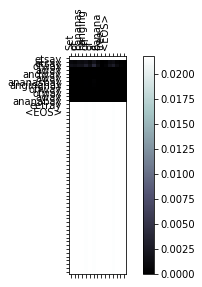

<Figure size 1500x1500 with 0 Axes>

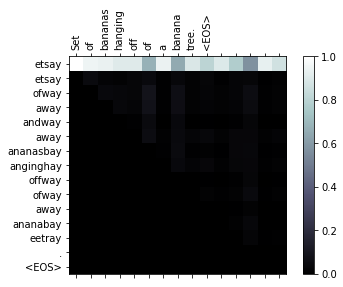

<Figure size 1500x1500 with 0 Axes>

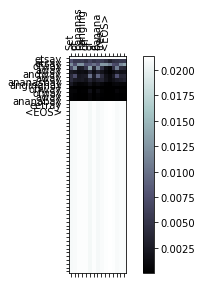

<Figure size 1500x1500 with 0 Axes>

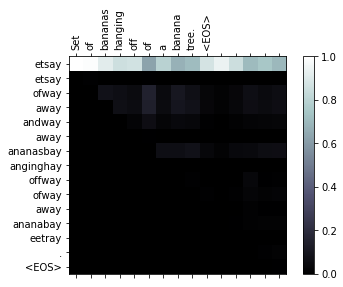

<Figure size 1500x1500 with 0 Axes>

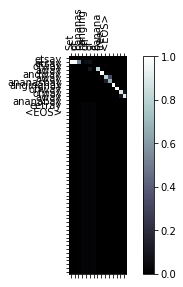

<Figure size 1500x1500 with 0 Axes>

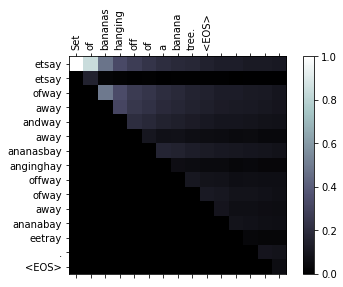

<Figure size 1500x1500 with 0 Axes>

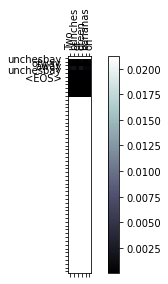

<Figure size 1500x1500 with 0 Axes>

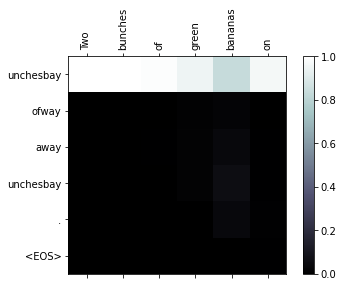

<Figure size 1500x1500 with 0 Axes>

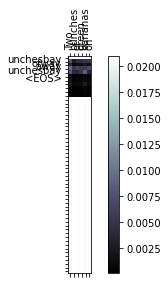

<Figure size 1500x1500 with 0 Axes>

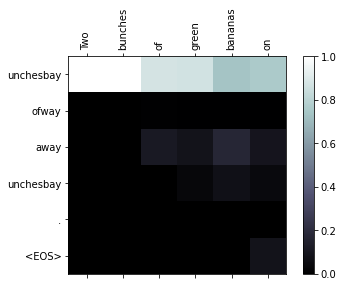

<Figure size 1500x1500 with 0 Axes>

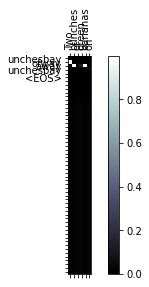

<Figure size 1500x1500 with 0 Axes>

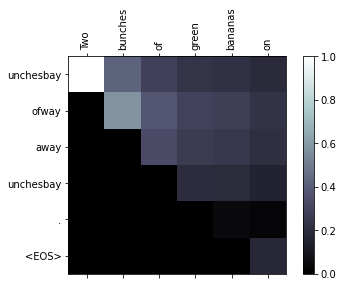

<Figure size 1500x1500 with 0 Axes>

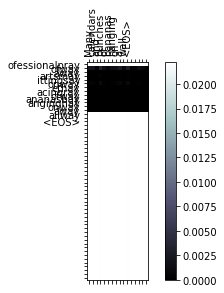

<Figure size 1500x1500 with 0 Axes>

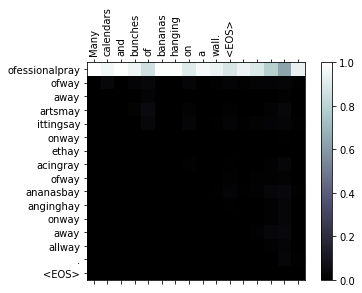

<Figure size 1500x1500 with 0 Axes>

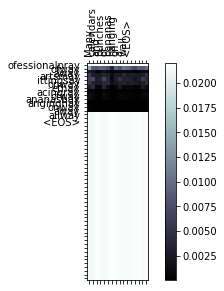

<Figure size 1500x1500 with 0 Axes>

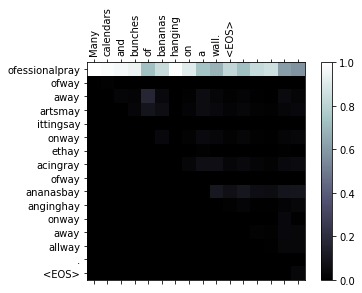

<Figure size 1500x1500 with 0 Axes>

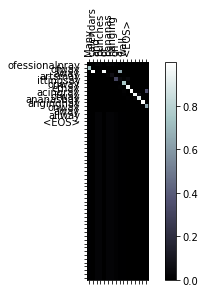

<Figure size 1500x1500 with 0 Axes>

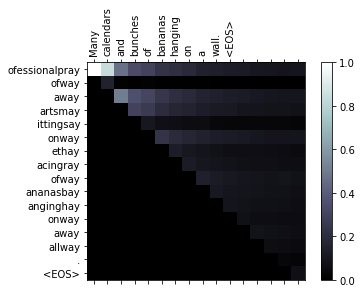

In [77]:
for idx, input_sentence in enumerate(val_sentences[:3]): 
    output_sentence, attentions = inference(input_sentence, encoder3, decoder3, decoderType="Transformer")
    encoder_attention_weights, self_attention_weights= attentions
    encoder_attention_weights = encoder_attention_weights.squeeze(1)
    self_attention_weights = self_attention_weights.squeeze(1)
    for i in range(3):
        showAttention(input_sentence, ' '.join(output_sentence[1:-1]), encoder_attention_weights.cpu().detach()[i])
        showAttention(input_sentence, ' '.join(output_sentence[1:-1]), self_attention_weights.cpu().detach()[i])

# 4. Effectiveness of word2vec

As an option, you may repeat one of the models above by modifying the code to use word2vec embedding for the input English sentences

In [ ]:
# Your code goes here